In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, "../")

In [3]:
import prfm

In [4]:
import numpy as np

In [50]:
Sigma_gas = 10
Sigma_star = 42
Omega_d = 28
H_star = 245

R = np.linspace(2, 16, 512)
R0 = 8
Re = 3.5

r0 = R / R0
re = R / Re

# to array
Sigma_gas = Sigma_gas / r0  # linear in R
Sigma_star = Sigma_star * np.exp((R0 / Re) - re)
Omega_d = Omega_d / r0  # flat rotation
H_star = H_star  # no flaring
sigma_eff = 15  # constant sigma_eff=15km/s

In [28]:
# parameters are given in astro-friendly units
mymodel = prfm.PRFM(
    Sigma_gas=Sigma_gas,
    Sigma_star=Sigma_star,
    H_star=H_star,
    Omega_d=Omega_d,
    sigma_eff=sigma_eff,
    astro_units=True,
)

In [29]:
mymodel

PRFM calculator is prepared for
  Sigma_gas[0]: 40.0, N=50
  Sigma_star[0]: 233.21373077544513, N=50
  rho_star[0]: 0.4759463893376431, N=50
  Omega_d[0]: 112.0, N=50
  rho_dm[0]: 0.23209463014478007, N=50
  sigma_eff[0]: 15.0, N=1

In [30]:
import matplotlib.pyplot as plt

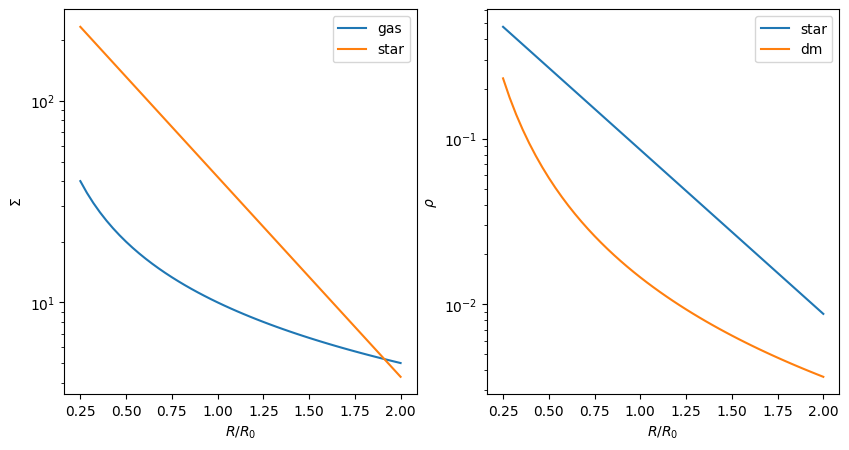

In [31]:
# model profiles
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(r0, calc.Sigma_gas, label="gas")
plt.plot(r0, calc.Sigma_star, label="star")
plt.ylabel(r"$\Sigma$")
plt.xlabel(r"$R/R_0$")
plt.legend()
plt.yscale("log")

plt.subplot(122)
plt.plot(r0, calc.rho_star, label="star")
plt.plot(r0, calc.rho_dm, label="dm")
plt.ylabel(r"$\rho$")
plt.xlabel(r"$R/R_0$")
plt.legend()
plt.yscale("log")

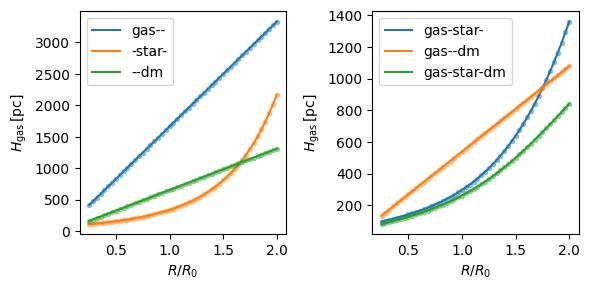

In [32]:
# sanity checks
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

labels = ["gas", "star", "dm"]
# gas, star, dm only scale heights
plt.sca(axes[0])
for wgas, wstar, wdm in [[1, 0, 0], [0, 1, 0], [0, 0, 1]]:
    H_ana = mymodel.get_scale_height(method="analytic", wgas=wgas, wstar=wstar, wdm=wdm)
    H_num = mymodel.get_scale_height(
        method="numerical", wgas=wgas, wstar=wstar, wdm=wdm
    )
    label = "-".join(
        [l if w_ == 1 else "" for w_, l in zip((wgas, wstar, wdm), labels)]
    )
    (l,) = plt.plot(r0, H_ana, label=label)
    plt.plot(r0, H_num, ".", color=l.get_color(), alpha=0.4)
plt.ylabel(r"$H_{\rm gas}\,[{\rm pc}]$")
plt.xlabel(r"$R/R_0$")
plt.legend()

# star-gas, dm-gas, and full scale heights
plt.sca(axes[1])
for wgas, wstar, wdm in [[1, 1, 0], [1, 0, 1], [1, 1, 1]]:
    H_ana = mymodel.get_scale_height(method="analytic", wgas=wgas, wstar=wstar, wdm=wdm)
    H_num = mymodel.get_scale_height(
        method="numerical", wgas=wgas, wstar=wstar, wdm=wdm
    )
    label = "-".join(
        [l if w_ == 1 else "" for w_, l in zip((wgas, wstar, wdm), labels)]
    )

    (l,) = plt.plot(r0, H_ana, label=label)
    plt.plot(r0, H_num, ".", color=l.get_color(), alpha=0.4)
plt.ylabel(r"$H_{\rm gas}\,[{\rm pc}]$")
plt.xlabel(r"$R/R_0$")
plt.legend()
plt.tight_layout()

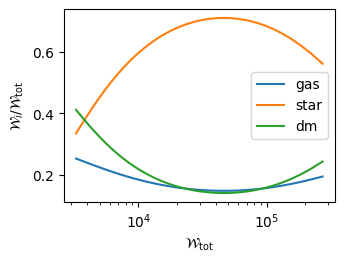

In [36]:
mymodel.calc_weights()
wfrac = mymodel.get_weight_contribution()
plt.figure(figsize=(3.5, 2.5))
plt.plot(mymodel.Wtot, wfrac[0], label="gas")
plt.plot(mymodel.Wtot, wfrac[1], label="star")
plt.plot(mymodel.Wtot, wfrac[2], label="dm")
plt.ylabel(r"$\mathcal{W}_i/\mathcal{W}_{\rm tot}$")
plt.xlabel(r"$\mathcal{W}_{\rm tot}$")
plt.xscale("log")
plt.legend()

In [57]:
# setting up three models with different velocity disersions
const_model = prfm.PRFM(
    Sigma_gas=Sigma_gas,
    Sigma_star=Sigma_star,
    H_star=H_star,
    Omega_d=Omega_d,
    sigma_eff=sigma_eff,
    astro_units=True,
)

tigress_mid_model = prfm.PRFM(
    Sigma_gas=Sigma_gas,
    Sigma_star=Sigma_star,
    H_star=H_star,
    Omega_d=Omega_d,
    sigma_eff="tigress_mid",
    astro_units=True,
)

tigress_avg_model = prfm.PRFM(
    Sigma_gas=Sigma_gas,
    Sigma_star=Sigma_star,
    H_star=H_star,
    Omega_d=Omega_d,
    sigma_eff="tigress_avg",
    astro_units=True,
)

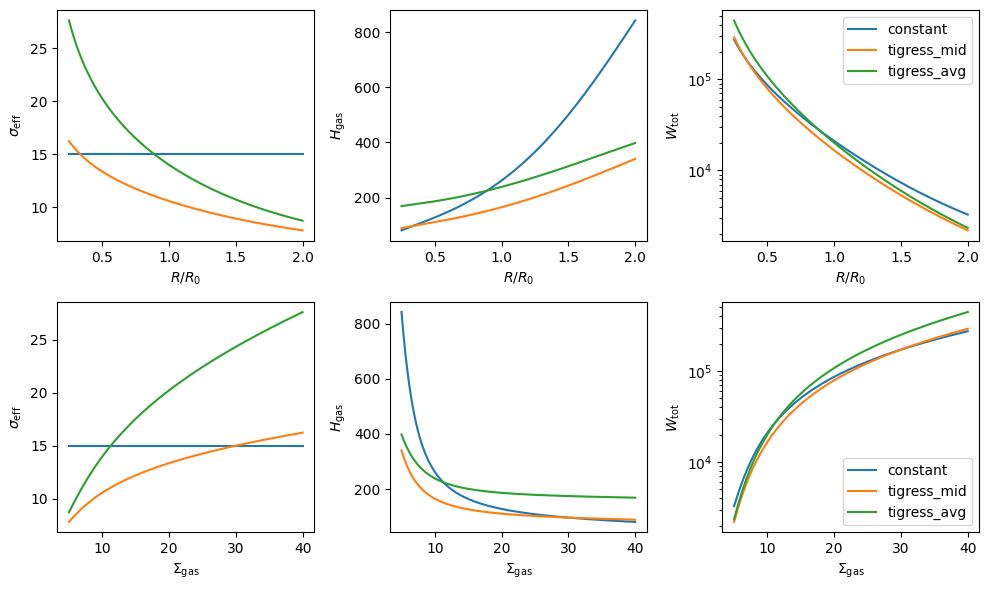

In [67]:
fig, axes_ = plt.subplots(2, 3, figsize=(10, 6))
axes = axes_[0, :]
for m in [const_model, tigress_mid_model, tigress_avg_model]:
    m.calc_self_consistent_solution()
    label = m.name
    for y, ax in zip([m.sigma_eff, m.H_gas, m.Wtot], axes):
        plt.sca(ax)
        plt.plot(r0, y * np.ones_like(r0), label=label)
xlab = r"$R/R_0$"
ylabels = [r"$\sigma_{\rm eff}$", r"$H_{\rm gas}$", r"$W_{\rm tot}$"]
for ax, ylab in zip(axes, ylabels):
    ax.set_ylabel(ylab)
    ax.set_xlabel(xlab)
plt.yscale("log")
# plt.xscale('log')
plt.legend()

axes = axes_[1, :]
for m in [const_model, tigress_mid_model, tigress_avg_model]:
    m.calc_self_consistent_solution(method="numerical")
    label = m.name
    for y, ax in zip([m.sigma_eff, m.H_gas, m.Wtot], axes):
        plt.sca(ax)
        plt.plot(m.Sigma_gas, y * np.ones_like(r0), label=label)
xlab = r"$\Sigma_{\rm gas}$"
ylabels = [r"$\sigma_{\rm eff}$", r"$H_{\rm gas}$", r"$W_{\rm tot}$"]
for ax, ylab in zip(axes, ylabels):
    ax.set_ylabel(ylab)
    ax.set_xlabel(xlab)
plt.yscale("log")
# plt.xscale('log')
plt.legend()
plt.tight_layout()

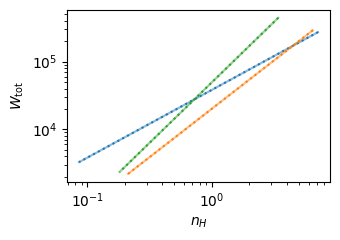

In [76]:
# sanity check for effective EOS
import astropy.constants as ac

fig = plt.figure(figsize=(3.5, 2.5))
ax = plt.subplot(111)
for m in [const_model, tigress_mid_model, tigress_avg_model]:
    rho_gas = m._Sigma_gas / (2 * m._H_gas)
    nH = rho_gas / (1.4 * ac.m_p.cgs.value)
    label = m.name

    (l,) = plt.plot(nH, m.Wtot, alpha=0.5, label=label)
    if hasattr(m, "_sigma_eff_model"):
        seff = prfm.get_sigma_eff(m._Wtot, model=m._sigma_eff_model)
    else:
        seff = m._sigma_eff
    plt.plot(
        nH, rho_gas * seff**2 / m.units["Wtot"].cgs.value, color=l.get_color(), ls=":"
    )

plt.sca(ax)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$n_H$")
plt.ylabel(r"$W_{\rm tot}$")
# plt.xscale('log')
plt.tight_layout()

difference between analytic and numerical solutions: 1.1521933629410341e-08


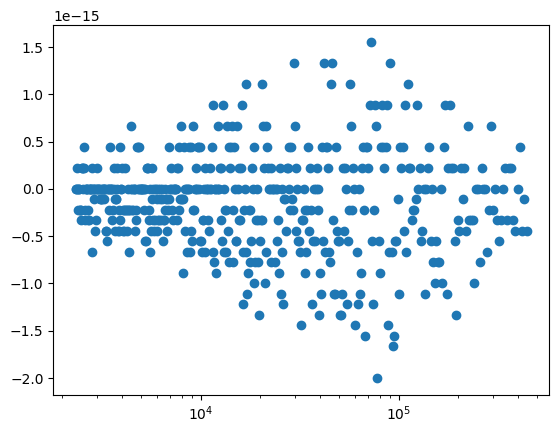

In [77]:
sola, soln = tigress_avg_model.check_solutions()
plt.plot(sola, soln / sola - 1, "o")
plt.xscale("log")

Text(0, 0.5, '$\\Sigma_{\\rm SFR}\\, [M_\\odot\\,{\\rm kpc^{-2}\\,yr^{-1}}]$')

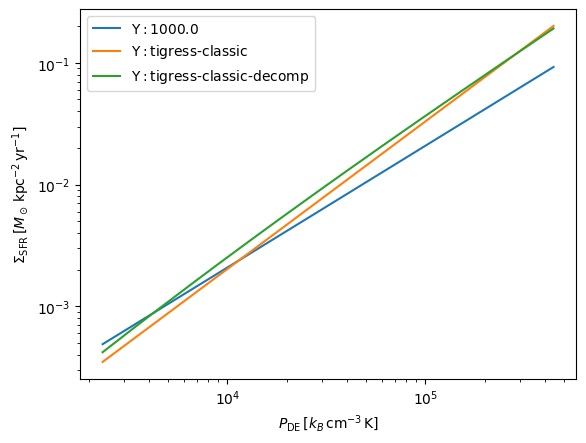

In [79]:
# Pressure-Sigma_SFR relation
for y in [1.0e3, "tigress-classic", "tigress-classic-decomp"]:
    tigress_avg_model.calc_sfr(Ytot=y)
    plt.plot(
        tigress_avg_model.Wtot,
        tigress_avg_model.Sigma_SFR,
        label=r"$\Upsilon:$" + "{}".format(y),
    )
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel(r"$P_{\rm DE}\, [k_B{\rm\,cm^{-3}\,K}]$")
plt.ylabel(r"$\Sigma_{\rm SFR}\, [M_\odot\,{\rm kpc^{-2}\,yr^{-1}}]$")